<a href="https://colab.research.google.com/github/PETEROA/ML-Optimization-Daily/blob/main/Pruning_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This work explores neural network pruning—the systematic removal of redundant parameters to create smaller, faster models. While quantisation reduces the precision of each parameter, pruning eliminates parameters entirely. I begin with the theoretical foundations: why are neural networks over-parameterized, and how can we identify which parameters to remove? I then implement key pruning strategies from scratch, including magnitude-based pruning, structured pruning (removing entire channels/filters), and gradual pruning schedules. This experimental framework compares these approaches on MNIST, measuring the sparsity-accuracy trade-off. I also explore the Lottery Ticket Hypothesis—the surprising finding that sparse subnetworks exist within dense networks that can match the original's accuracy when trained in isolation. The analysis connects pruning to broader research themes including neural architecture search (pruning as implicit architecture search), knowledge distillation (pruning + distillation pipelines), and efficient deployment for CompressML.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List, Dict, Tuple, Callable
from dataclasses import dataclass
from copy import deepcopy
from collections import OrderedDict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
class PruningMask:
    """
    Manages binary masks for weight pruning.
    The mask is a tensor of 0s and 1s with the same shape as the weight.
    Pruned weights are multiplied by 0, kept weights by 1.
    """

    def __init__(self, weight: torch.Tensor):
        """
        Initialize mask (all ones = nothing pruned).

        Args:
            weight: Weight tensor to create mask for
        """
        self.mask = torch.ones_like(weight, dtype=torch.bool)
        self.shape = weight.shape

    def apply(self, weight: torch.Tensor) -> torch.Tensor:
        """Apply mask to weight tensor."""
        return weight * self.mask.float()

    @property
    def sparsity(self) -> float:
        """Current sparsity (fraction of zeros)."""
        return 1.0 - self.mask.float().mean().item()

    @property
    def num_pruned(self) -> int:
        """Number of pruned (zeroed) weights."""
        return (~self.mask).sum().item()

    @property
    def num_remaining(self) -> int:
        """Number of remaining (non-zero) weights."""
        return self.mask.sum().item()

In [3]:
class MagnitudePruner:
    """
    Magnitude-based weight pruning.
    The simplest and most common pruning method: remove weights with
    the smallest absolute values. Surprisingly competitive with more
    sophisticated methods.
    Supports both local (per-layer) and global (across all layers) pruning.
    """

    def __init__(self, model: nn.Module, prune_biases: bool = False):
        """
        Args:
            model: Model to prune
            prune_biases: Whether to prune bias terms (usually False)
        """
        self.model = model
        self.prune_biases = prune_biases
        self.masks: Dict[str, PruningMask] = {}

        # Initialize masks for all prunable parameters
        for name, param in model.named_parameters():
            if self._is_prunable(name, param):
                self.masks[name] = PruningMask(param.data)

    def _is_prunable(self, name: str, param: torch.Tensor) -> bool:
        """Check if parameter should be pruned."""
        if 'bias' in name and not self.prune_biases:
            return False
        if param.dim() < 2:  # Don't prune 1D params like BatchNorm
            return False
        return True

    def compute_importance(self, name: str, param: torch.Tensor) -> torch.Tensor:
        """
        Compute importance scores for parameters.

        For magnitude pruning, importance = |weight|.
        Override this method for other criteria.
        """
        return param.data.abs()

    def prune_local(self, sparsity: float):
        """
        Local pruning: prune each layer to the same sparsity.

        Args:
            sparsity: Target sparsity (0.9 = 90% zeros)
        """
        for name, param in self.model.named_parameters():
            if name not in self.masks:
                continue

            importance = self.compute_importance(name, param)
            mask = self.masks[name]

            # Only consider currently unpruned weights
            importance = importance * mask.mask.float()

            # Find threshold for this layer
            k = int(mask.num_remaining * (1 - sparsity))  # Keep this many
            if k == 0:
                k = 1  # Keep at least one weight

            # Get threshold value
            flat_importance = importance[mask.mask].flatten()
            if len(flat_importance) > k:
                threshold = torch.kthvalue(flat_importance, len(flat_importance) - k + 1)[0]
                mask.mask = mask.mask & (importance >= threshold)

    def prune_global(self, sparsity: float):

        # Collect all importance scores
        all_scores = []
        score_to_mask_idx = []  # Track which mask each score belongs to

        for name, param in self.model.named_parameters():
            if name not in self.masks:
                continue

            importance = self.compute_importance(name, param)
            mask = self.masks[name]

            # Only consider currently unpruned weights
            valid_importance = importance[mask.mask]
            all_scores.append(valid_importance.flatten())
            score_to_mask_idx.extend([(name, i) for i in range(len(valid_importance.flatten()))])

        # Concatenate and find global threshold
        all_scores = torch.cat(all_scores)
        total_weights = len(all_scores)
        k = int(total_weights * (1 - sparsity))  # Keep this many
        k = max(k, 1)

        if total_weights > k:
            threshold = torch.kthvalue(all_scores, total_weights - k + 1)[0]
        else:
            threshold = all_scores.min() - 1  # Keep all

        # Apply threshold to each layer
        for name, param in self.model.named_parameters():
            if name not in self.masks:
                continue

            importance = self.compute_importance(name, param)
            mask = self.masks[name]
            mask.mask = mask.mask & (importance >= threshold)

    def apply_masks(self):
        """Apply all masks to model weights."""
        for name, param in self.model.named_parameters():
            if name in self.masks:
                param.data = self.masks[name].apply(param.data)

    def get_sparsity(self) -> Dict[str, float]:
        """Get sparsity for each layer and overall."""
        sparsities = {}
        total_pruned = 0
        total_params = 0

        for name, mask in self.masks.items():
            sparsities[name] = mask.sparsity
            total_pruned += mask.num_pruned
            total_params += mask.mask.numel()

        sparsities['overall'] = total_pruned / total_params if total_params > 0 else 0
        return sparsities

    def reset_masks(self):
        """Reset all masks to unpruned state."""
        for name, param in self.model.named_parameters():
            if name in self.masks:
                self.masks[name] = PruningMask(param.data)

In [4]:
class GradientPruner(MagnitudePruner):
    """
    Gradient-based pruning using weight × gradient as importance.
    This approximates the effect of removing each weight on the loss.
    Requires computing gradients on a data batch.
    """

    def __init__(self, model: nn.Module, prune_biases: bool = False):
        super().__init__(model, prune_biases)
        self.gradients: Dict[str, torch.Tensor] = {}

    def compute_gradients(self, dataloader: DataLoader, num_batches: int = 10):

        self.model.train()

        # Accumulate gradients
        for name, param in self.model.named_parameters():
            if name in self.masks:
                self.gradients[name] = torch.zeros_like(param.data)

        count = 0
        for data, target in dataloader:
            if count >= num_batches:
                break

            data, target = data.to(device), target.to(device)
            self.model.zero_grad()
            output = self.model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()

            for name, param in self.model.named_parameters():
                if name in self.gradients and param.grad is not None:
                    self.gradients[name] += param.grad.data.abs()

            count += 1

        # Average
        for name in self.gradients:
            self.gradients[name] /= count

    def compute_importance(self, name: str, param: torch.Tensor) -> torch.Tensor:


        if name in self.gradients:
            return (param.data.abs() * self.gradients[name])
        else:
            return param.data.abs()  # Fallback to magnitude

In [5]:
class GradualPruner:
    """
    Gradual pruning with cubic sparsity schedule.
    Instead of pruning to target sparsity at once, gradually increase
    sparsity over training. This gives the network time to adapt.

    """

    def __init__(
        self,
        pruner: MagnitudePruner,
        initial_sparsity: float = 0.0,
        final_sparsity: float = 0.9,
        start_step: int = 0,
        end_step: int = 1000,
        pruning_frequency: int = 100
    ):

        self.pruner = pruner
        self.initial_sparsity = initial_sparsity
        self.final_sparsity = final_sparsity
        self.start_step = start_step
        self.end_step = end_step
        self.pruning_frequency = pruning_frequency
        self.current_step = 0

    def get_current_sparsity(self) -> float:
        """
        Compute sparsity for current step using cubic schedule.
        """
        if self.current_step < self.start_step:
            return self.initial_sparsity
        elif self.current_step >= self.end_step:
            return self.final_sparsity
        else:
            progress = (self.current_step - self.start_step) / (self.end_step - self.start_step)
            # Cubic schedule: starts slow, accelerates, then slows
            return self.final_sparsity + (self.initial_sparsity - self.final_sparsity) * (1 - progress) ** 3

    def step(self, global_prune: bool = True):

        self.current_step += 1

        # Check if we should prune this step
        if self.current_step < self.start_step:
            return
        if self.current_step > self.end_step:
            return
        if (self.current_step - self.start_step) % self.pruning_frequency != 0:
            return

        # Prune to current target sparsity
        target_sparsity = self.get_current_sparsity()

        # Reset masks and re-prune (allows weights to "grow back")
        self.pruner.reset_masks()

        if global_prune:
            self.pruner.prune_global(target_sparsity)
        else:
            self.pruner.prune_local(target_sparsity)

        self.pruner.apply_masks()

In [16]:
class StructuredPruner:
    """
    Structured pruning: remove entire neurons/channels.
    Unlike unstructured pruning, this changes the actual architecture,
    resulting in real speedup on standard hardware.
    For Linear layers: remove neurons (rows of weight matrix)
    For Conv layers: remove filters (output channels)
    """

    def __init__(self, model: nn.Module):
        """
        Args:
            model: Model to prune
        """
        self.model = model
        self.neuron_masks: Dict[str, torch.Tensor] = {}  # 1D masks for neurons/channels

        # Determine the device from the model's parameters
        # Assuming all model parameters are on the same device
        if model.named_parameters():
            # Get the device of the first parameter
            _, first_param = next(iter(model.named_parameters()))
            self.device = first_param.device
        else:
            # Fallback to CPU if no parameters (e.g., empty model)
            self.device = torch.device('cpu')

        # Initialize neuron masks
        for name, module in model.named_modules():
            if isinstance(module, nn.Linear):
                # Mask for output neurons
                # Initialize on the same device as the model
                self.neuron_masks[name] = torch.ones(module.out_features, dtype=torch.bool, device=self.device)

    def compute_neuron_importance(self, name: str, module: nn.Module) -> torch.Tensor:

        if isinstance(module, nn.Linear):
            # Each row of weight matrix is a neuron's incoming weights
            # Importance = L2 norm of that row
            return module.weight.data.norm(dim=1)
        else:
            raise NotImplementedError(f"Structured pruning not implemented for {type(module)}")

    def prune_neurons(self, sparsity: float, layer_name: Optional[str] = None):

        for name, module in self.model.named_modules():
            if not isinstance(module, nn.Linear):
                continue
            if layer_name is not None and name != layer_name:
                continue
            if name not in self.neuron_masks:
                continue

            importance = self.compute_neuron_importance(name, module)
            mask = self.neuron_masks[name]

            # Only consider currently unpruned neurons
            num_remaining = mask.sum().item()
            k = int(num_remaining * (1 - sparsity))
            k = max(k, 1)  # Keep at least one neuron

            # Find threshold
            valid_importance = importance[mask]
            if len(valid_importance) > k:
                threshold = torch.kthvalue(valid_importance, len(valid_importance) - k + 1)[0]
                self.neuron_masks[name] = mask & (importance >= threshold)

    def apply_masks(self):

        for name, module in self.model.named_modules():
            if name not in self.neuron_masks:
                continue

            mask = self.neuron_masks[name]

            if isinstance(module, nn.Linear):
                # Zero out pruned neurons' outgoing weights
                module.weight.data[~mask] = 0
                if module.bias is not None:
                    module.bias.data[~mask] = 0

    def get_neuron_sparsity(self) -> Dict[str, float]:
        """Get neuron sparsity for each layer."""
        sparsities = {}
        for name, mask in self.neuron_masks.items():
            sparsities[name] = 1.0 - mask.float().mean().item()
        return sparsities

    def get_actual_architecture(self) -> Dict[str, int]:
        """Get the effective architecture after pruning."""
        arch = {}
        for name, mask in self.neuron_masks.items():
            arch[name] = mask.sum().item()
        return arch

In [7]:
# Model for experiments

class SimpleMLP(nn.Module):
    """
    Simple MLP for pruning experiments.
    """

    def __init__(self, hidden_dims: List[int] = [512, 256, 128]):
        super().__init__()

        layers = []
        prev_dim = 784

        for i, hidden_dim in enumerate(hidden_dims):
            layers.append((f'fc{i+1}', nn.Linear(prev_dim, hidden_dim)))
            layers.append((f'relu{i+1}', nn.ReLU()))
            prev_dim = hidden_dim

        layers.append(('fc_out', nn.Linear(prev_dim, 10)))

        self.layers = nn.Sequential(OrderedDict(layers))
        self.hidden_dims = hidden_dims

        # Initialize
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

In [8]:
# Data loading

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:14<00:00, 682kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.43MB/s]

Train samples: 60000
Test samples: 10000


In [9]:
# Training utilities

def train_epoch(model, train_loader, optimizer, pruner=None):
    """Train for one epoch, optionally applying pruning mask."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        # Re-apply mask after optimizer step
        if pruner is not None:
            pruner.apply_masks()

        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += data.size(0)

    return total_loss / total, correct / total


def evaluate(model, test_loader):
    """Evaluate model accuracy."""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)

    return correct / total


def count_parameters(model):
    """Count total and non-zero parameters."""
    total = 0
    nonzero = 0
    for param in model.parameters():
        total += param.numel()
        nonzero += (param != 0).sum().item()
    return total, nonzero

In [10]:
#Unstructured Pruning experiments
# Train baseline model

print("=" * 70)
print("TRAINING BASELINE MODEL")
print("=" * 70)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model = SimpleMLP(hidden_dims=[512, 256, 128]).to(device)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

for epoch in range(5):
    train_loss, train_acc = train_epoch(baseline_model, train_loader, optimizer)
    test_acc = evaluate(baseline_model, test_loader)
    print(f"Epoch {epoch+1}: Train Acc={100*train_acc:.2f}%, Test Acc={100*test_acc:.2f}%")

baseline_acc = evaluate(baseline_model, test_loader)
total_params, nonzero_params = count_parameters(baseline_model)
print(f"\nBaseline: {100*baseline_acc:.2f}% accuracy, {total_params:,} parameters")

# Save baseline state
baseline_state = deepcopy(baseline_model.state_dict())

TRAINING BASELINE MODEL
Epoch 1: Train Acc=93.77%, Test Acc=96.55%
Epoch 2: Train Acc=97.40%, Test Acc=96.73%
Epoch 3: Train Acc=98.09%, Test Acc=97.60%
Epoch 4: Train Acc=98.47%, Test Acc=97.61%
Epoch 5: Train Acc=98.81%, Test Acc=97.81%

Baseline: 97.81% accuracy, 567,434 parameters


In [11]:
# Experiment 1: One-shot magnitude pruning at different sparsities

print("\n" + "=" * 70)
print("EXPERIMENT 1: One-Shot Magnitude Pruning")
print("=" * 70)
print("\nPruning pre-trained model, then evaluating (no fine-tuning).\n")

sparsities = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99]
oneshot_results = {'local': {}, 'global': {}}

for mode in ['local', 'global']:
    print(f"\n{mode.upper()} pruning:")

    for sparsity in sparsities:
        # Load baseline weights
        model = SimpleMLP(hidden_dims=[512, 256, 128]).to(device)
        model.load_state_dict(deepcopy(baseline_state))

        # Prune
        pruner = MagnitudePruner(model)
        if mode == 'local':
            pruner.prune_local(sparsity)
        else:
            pruner.prune_global(sparsity)
        pruner.apply_masks()

        # Evaluate
        acc = evaluate(model, test_loader)
        actual_sparsity = pruner.get_sparsity()['overall']

        oneshot_results[mode][sparsity] = {
            'accuracy': acc,
            'actual_sparsity': actual_sparsity
        }

        print(f"  {100*sparsity:.0f}% target → {100*actual_sparsity:.1f}% actual: {100*acc:.2f}% acc")


EXPERIMENT 1: One-Shot Magnitude Pruning

Pruning pre-trained model, then evaluating (no fine-tuning).


LOCAL pruning:
  50% target → 50.0% actual: 97.57% acc
  70% target → 70.0% actual: 95.18% acc
  80% target → 80.0% actual: 90.69% acc
  90% target → 90.0% actual: 54.06% acc
  95% target → 95.0% actual: 40.31% acc
  99% target → 99.0% actual: 9.74% acc

GLOBAL pruning:
  50% target → 50.0% actual: 97.67% acc
  70% target → 70.0% actual: 97.48% acc
  80% target → 80.0% actual: 96.75% acc
  90% target → 90.0% actual: 90.84% acc
  95% target → 95.0% actual: 65.43% acc
  99% target → 99.0% actual: 16.96% acc


In [12]:
# Experiment 2: One-shot pruning WITH fine-tuning

print("\n" + "=" * 70)
print("EXPERIMENT 2: One-Shot Pruning + Fine-Tuning")
print("=" * 70)
print("\nPruning, then fine-tuning for 3 epochs.\n")

finetuned_results = {}

for sparsity in [0.9, 0.95, 0.99]:
    print(f"\n{100*sparsity:.0f}% sparsity:")

    # Load baseline
    model = SimpleMLP(hidden_dims=[512, 256, 128]).to(device)
    model.load_state_dict(deepcopy(baseline_state))

    # Prune (global)
    pruner = MagnitudePruner(model)
    pruner.prune_global(sparsity)
    pruner.apply_masks()

    before_finetune = evaluate(model, test_loader)
    print(f"  Before fine-tuning: {100*before_finetune:.2f}%")

    # Fine-tune (with mask applied after each step)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(3):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, pruner)
        test_acc = evaluate(model, test_loader)
        print(f"  Epoch {epoch+1}: {100*test_acc:.2f}%")

    finetuned_results[sparsity] = {
        'before': before_finetune,
        'after': test_acc
    }


EXPERIMENT 2: One-Shot Pruning + Fine-Tuning

Pruning, then fine-tuning for 3 epochs.


90% sparsity:
  Before fine-tuning: 90.84%
  Epoch 1: 96.96%
  Epoch 2: 97.35%
  Epoch 3: 97.67%

95% sparsity:
  Before fine-tuning: 65.43%
  Epoch 1: 93.88%
  Epoch 2: 95.39%
  Epoch 3: 96.04%

99% sparsity:
  Before fine-tuning: 16.96%
  Epoch 1: 59.70%
  Epoch 2: 71.11%
  Epoch 3: 80.15%


In [13]:
# Experiment 3: Gradual pruning

print("\n" + "=" * 70)
print("EXPERIMENT 3: Gradual Pruning")
print("=" * 70)
print("\nPruning gradually during training with cubic schedule.\n")

gradual_results = {}

for target_sparsity in [0.9, 0.95]:
    print(f"\nTarget sparsity: {100*target_sparsity:.0f}%")

    # Fresh model
    model = SimpleMLP(hidden_dims=[512, 256, 128]).to(device)
    model.load_state_dict(deepcopy(baseline_state))

    pruner = MagnitudePruner(model)

    # Calculate steps
    steps_per_epoch = len(train_loader)
    total_epochs = 5
    total_steps = steps_per_epoch * total_epochs

    gradual = GradualPruner(
        pruner,
        initial_sparsity=0.0,
        final_sparsity=target_sparsity,
        start_step=0,
        end_step=int(total_steps * 0.8),  # Reach target at 80% of training
        pruning_frequency=steps_per_epoch // 2  # Prune twice per epoch
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    sparsity_history = []
    acc_history = []

    for epoch in range(total_epochs):
        model.train()

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            # Gradual pruning step
            gradual.step(global_prune=True)

        test_acc = evaluate(model, test_loader)
        current_sparsity = pruner.get_sparsity()['overall']

        sparsity_history.append(current_sparsity)
        acc_history.append(test_acc)

        print(f"  Epoch {epoch+1}: {100*current_sparsity:.1f}% sparse, {100*test_acc:.2f}% acc")

    gradual_results[target_sparsity] = {
        'final_accuracy': test_acc,
        'sparsity_history': sparsity_history,
        'acc_history': acc_history
    }


EXPERIMENT 3: Gradual Pruning

Pruning gradually during training with cubic schedule.


Target sparsity: 90%
  Epoch 1: 52.0% sparse, 97.58% acc
  Epoch 2: 78.7% sparse, 97.75% acc
  Epoch 3: 88.6% sparse, 97.86% acc
  Epoch 4: 90.0% sparse, 97.95% acc
  Epoch 5: 90.0% sparse, 97.90% acc

Target sparsity: 95%
  Epoch 1: 54.8% sparse, 97.49% acc
  Epoch 2: 83.0% sparse, 96.66% acc
  Epoch 3: 93.5% sparse, 97.69% acc
  Epoch 4: 95.0% sparse, 97.50% acc
  Epoch 5: 95.0% sparse, 97.81% acc


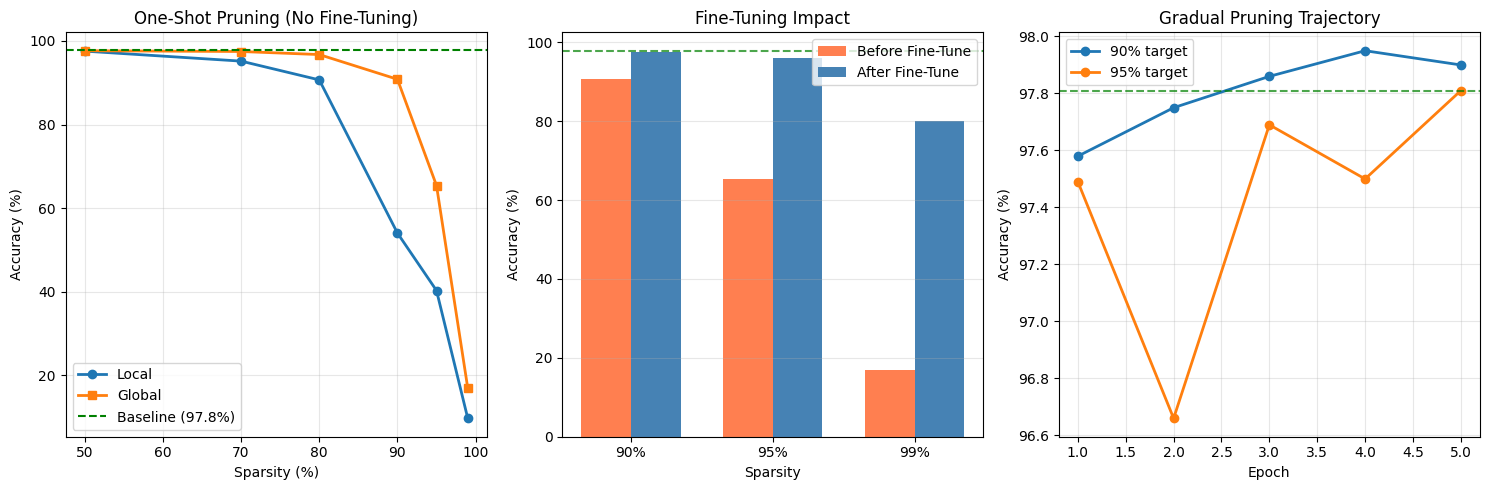

In [14]:
# Visualize unstructured pruning results

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: One-shot pruning comparison
ax = axes[0]
local_accs = [oneshot_results['local'][s]['accuracy'] * 100 for s in sparsities]
global_accs = [oneshot_results['global'][s]['accuracy'] * 100 for s in sparsities]

ax.plot([s*100 for s in sparsities], local_accs, 'o-', label='Local', linewidth=2)
ax.plot([s*100 for s in sparsities], global_accs, 's-', label='Global', linewidth=2)
ax.axhline(y=baseline_acc * 100, color='green', linestyle='--', label=f'Baseline ({baseline_acc*100:.1f}%)')

ax.set_xlabel('Sparsity (%)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('One-Shot Pruning (No Fine-Tuning)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Fine-tuning impact
ax = axes[1]
ft_sparsities = list(finetuned_results.keys())
before = [finetuned_results[s]['before'] * 100 for s in ft_sparsities]
after = [finetuned_results[s]['after'] * 100 for s in ft_sparsities]

x = np.arange(len(ft_sparsities))
width = 0.35

ax.bar(x - width/2, before, width, label='Before Fine-Tune', color='coral')
ax.bar(x + width/2, after, width, label='After Fine-Tune', color='steelblue')
ax.axhline(y=baseline_acc * 100, color='green', linestyle='--', alpha=0.7)

ax.set_xlabel('Sparsity')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Fine-Tuning Impact')
ax.set_xticks(x)
ax.set_xticklabels([f'{s*100:.0f}%' for s in ft_sparsities])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Gradual pruning trajectory
ax = axes[2]
for target, result in gradual_results.items():
    epochs = range(1, len(result['acc_history']) + 1)
    ax.plot(epochs, [a*100 for a in result['acc_history']], 'o-',
            label=f'{target*100:.0f}% target', linewidth=2)

ax.axhline(y=baseline_acc * 100, color='green', linestyle='--', alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Gradual Pruning Trajectory')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('unstructured_pruning.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
#Structured Pruning Experiments
# Experiment 4: Structured (neuron) pruning

print("\n" + "=" * 70)
print("EXPERIMENT 4: Structured Pruning (Neurons)")
print("=" * 70)
print("\nRemoving entire neurons based on L2 norm of incoming weights.\n")

structured_results = {}

for neuron_sparsity in [0.25, 0.5, 0.75]:
    print(f"\n{100*neuron_sparsity:.0f}% neuron sparsity:")

    # Load baseline
    model = SimpleMLP(hidden_dims=[512, 256, 128]).to(device)
    model.load_state_dict(deepcopy(baseline_state))

    # Structured prune
    struct_pruner = StructuredPruner(model)
    struct_pruner.prune_neurons(neuron_sparsity)
    struct_pruner.apply_masks()

    # Get effective architecture
    arch = struct_pruner.get_actual_architecture()
    print(f"  Effective architecture: {arch}")

    # Evaluate before fine-tuning
    before_acc = evaluate(model, test_loader)
    print(f"  Before fine-tuning: {100*before_acc:.2f}%")

    # Fine-tune
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    for epoch in range(3):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            struct_pruner.apply_masks()  # Keep pruned neurons at zero

    after_acc = evaluate(model, test_loader)
    print(f"  After fine-tuning: {100*after_acc:.2f}%")

    # Calculate actual parameter reduction
    total, nonzero = count_parameters(model)
    param_reduction = 1 - nonzero / total

    structured_results[neuron_sparsity] = {
        'architecture': arch,
        'before': before_acc,
        'after': after_acc,
        'param_reduction': param_reduction
    }
    print(f"  Parameter reduction: {100*param_reduction:.1f}%")


EXPERIMENT 4: Structured Pruning (Neurons)

Removing entire neurons based on L2 norm of incoming weights.


25% neuron sparsity:
  Effective architecture: {'layers.fc1': 384, 'layers.fc2': 192, 'layers.fc3': 96, 'layers.fc_out': 7}
  Before fine-tuning: 68.04%
  After fine-tuning: 79.25%
  Parameter reduction: 25.0%

50% neuron sparsity:
  Effective architecture: {'layers.fc1': 256, 'layers.fc2': 128, 'layers.fc3': 64, 'layers.fc_out': 5}
  Before fine-tuning: 41.94%
  After fine-tuning: 59.64%
  Parameter reduction: 50.0%

75% neuron sparsity:
  Effective architecture: {'layers.fc1': 128, 'layers.fc2': 64, 'layers.fc3': 32, 'layers.fc_out': 2}
  Before fine-tuning: 23.24%
  After fine-tuning: 30.58%
  Parameter reduction: 75.0%


In [18]:
# Compare structured vs unstructured

print("\n" + "=" * 70)
print("COMPARISON: Structured vs Unstructured")
print("=" * 70)

print("\nAt similar parameter reduction levels:\n")
print(f"{'Method':<25} {'Param Reduction':<18} {'Accuracy':<12} {'Actual Speedup'}")
print("-" * 70)

# Unstructured at 90%
print(f"{'Unstructured 90%':<25} {'90%':<18} {100*finetuned_results[0.9]['after']:.2f}%       {'No (sparse ops)':<15}")

# Structured at 50% neurons ≈ 75% params for this architecture
sr = structured_results[0.5]
print(f"{'Structured 50% neurons':<25} {100*sr['param_reduction']:.0f}%{'':<16} {100*sr['after']:.2f}%       {'Yes (smaller arch)':<15}")


COMPARISON: Structured vs Unstructured

At similar parameter reduction levels:

Method                    Param Reduction    Accuracy     Actual Speedup
----------------------------------------------------------------------
Unstructured 90%          90%                97.67%       No (sparse ops)
Structured 50% neurons    50%                 59.64%       Yes (smaller arch)


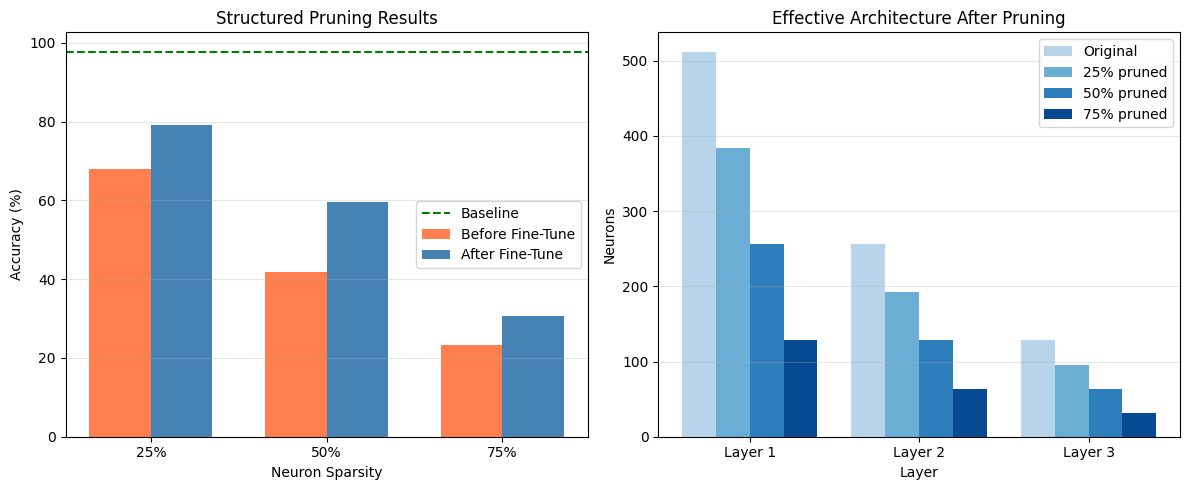

In [19]:
# Visualize structured pruning

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Accuracy vs neuron sparsity
ax = axes[0]
spars = list(structured_results.keys())
before = [structured_results[s]['before'] * 100 for s in spars]
after = [structured_results[s]['after'] * 100 for s in spars]

x = np.arange(len(spars))
width = 0.35

ax.bar(x - width/2, before, width, label='Before Fine-Tune', color='coral')
ax.bar(x + width/2, after, width, label='After Fine-Tune', color='steelblue')
ax.axhline(y=baseline_acc * 100, color='green', linestyle='--', label='Baseline')

ax.set_xlabel('Neuron Sparsity')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Structured Pruning Results')
ax.set_xticks(x)
ax.set_xticklabels([f'{s*100:.0f}%' for s in spars])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Effective architecture visualization
ax = axes[1]

original_dims = [512, 256, 128]
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(spars) + 1))

x = np.arange(3)  # 3 hidden layers
width = 0.2

ax.bar(x - 1.5*width, original_dims, width, label='Original', color=colors[0])

for i, s in enumerate(spars):
    arch = structured_results[s]['architecture']
    dims = [arch.get(f'layers.fc{j+1}', original_dims[j]) for j in range(3)]
    ax.bar(x + (i - 0.5)*width, dims, width, label=f'{s*100:.0f}% pruned', color=colors[i+1])

ax.set_xlabel('Layer')
ax.set_ylabel('Neurons')
ax.set_title('Effective Architecture After Pruning')
ax.set_xticks(x)
ax.set_xticklabels(['Layer 1', 'Layer 2', 'Layer 3'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('structured_pruning.png', dpi=150, bbox_inches='tight')
plt.show()